In [276]:
import pygeohash as gh
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

sys.path.append(os.path.dirname(sys.path[0]))

from uk_road_safety.python.data_cleaning import prepare_data_for_groupby
from uk_road_safety.python.data_cleaning import prepare_data
from uk_road_safety.python.grouped_data import data_for_analysis
from uk_road_safety.python import mlmodel
import tensorflow as tf

import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df_accidents=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/preprocessed-1999-2021.csv')
df_accidents['date']=pd.to_datetime(df_accidents['date'])

# Entire UK

In [325]:
time_series=data_for_analysis(df_accidents)
time_series.tail(25)

,Accidents
date,
2019-12-31,9970
2020-01-31,9591
2020-02-29,8542
2020-03-31,6549
2020-04-30,3298
2020-05-31,5598
2020-06-30,6720
2020-07-31,8157
2020-08-31,8874


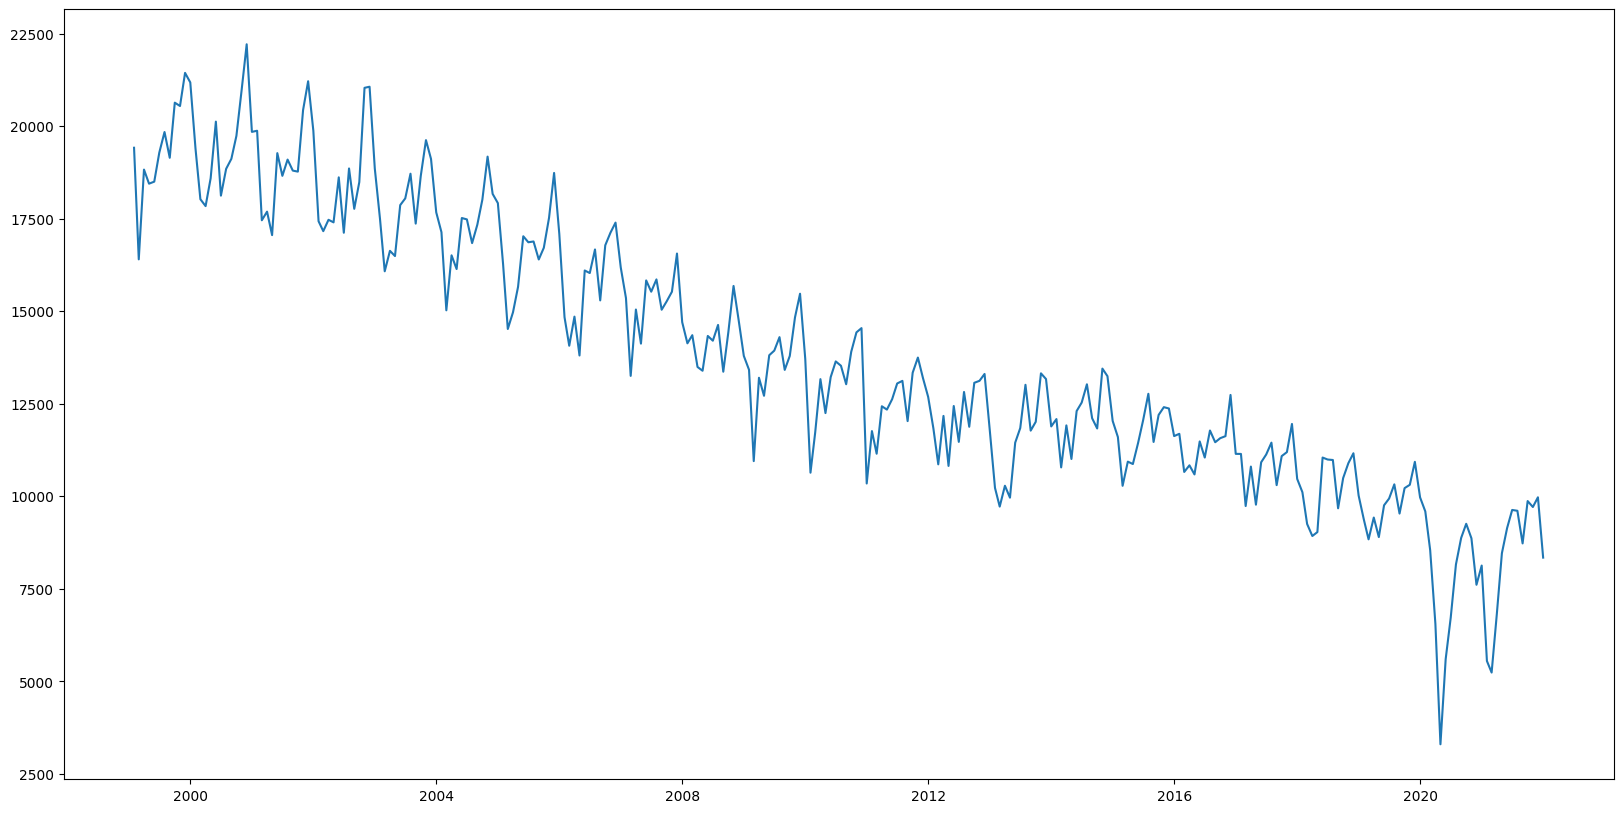

In [217]:
plt.figure(figsize=(20,10))
plt.plot(time_series);

Text(0.5, 1.0, 'Multiplicative residuals plot')

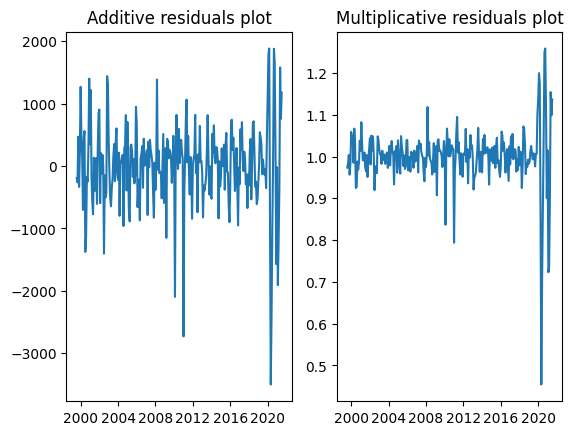

In [347]:
result_add_2019 = seasonal_decompose(time_series['Accidents'], model='additive')
result_mul_2019 = seasonal_decompose(time_series['Accidents'], model='multiplicative')
plt.subplot(1,2,1)
plt.plot(result_add_2019.resid)
plt.title('Additive residuals plot')
plt.subplot(1,2,2)
plt.plot(result_mul_2019.resid)
plt.title('Multiplicative residuals plot')

In [220]:
adfuller(time_series['Accidents'])[1]

0.7192577637165356

In [221]:
adfuller(result_add.resid.dropna())[1]

5.986858316453987e-11

In [222]:
adfuller(result_mul.resid.dropna())[1]

2.57326991610031e-10

In [327]:
time_series['deseasonalized']=time_series['Accidents'].values-result_add.seasonal

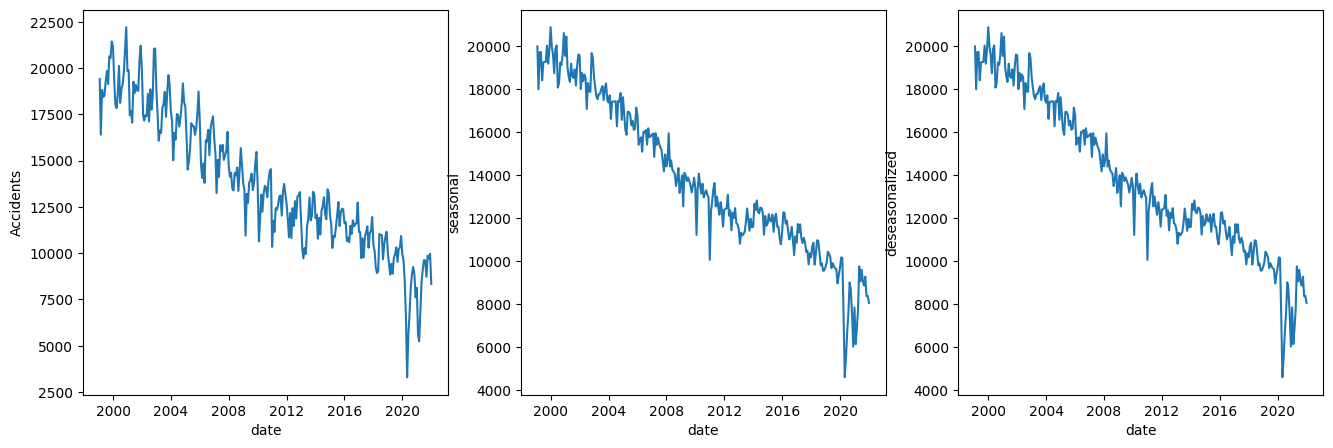

In [224]:
fig, axes = plt.subplots(1,3, figsize=(16,5))

sns.lineplot(time_series['Accidents'], ax=axes[0])
sns.lineplot(time_series['Accidents'].values-result_add.seasonal, ax=axes[1])
sns.lineplot(time_series['deseasonalized'], ax=axes[2]);

In [328]:
time_series_2019=time_series.head(time_series.shape[0]-24)
time_series_2019

,Accidents,deseasonalized
date,,
1999-01-31,19418,19999.456439
1999-02-28,16402,18002.244318
1999-03-31,18828,19737.935606
1999-04-30,18447,19738.659091
1999-05-31,18502,18422.369318
...,...,...
2019-08-31,9532,9662.454545
2019-09-30,10220,9620.662879
2019-10-31,10310,8960.787879


/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


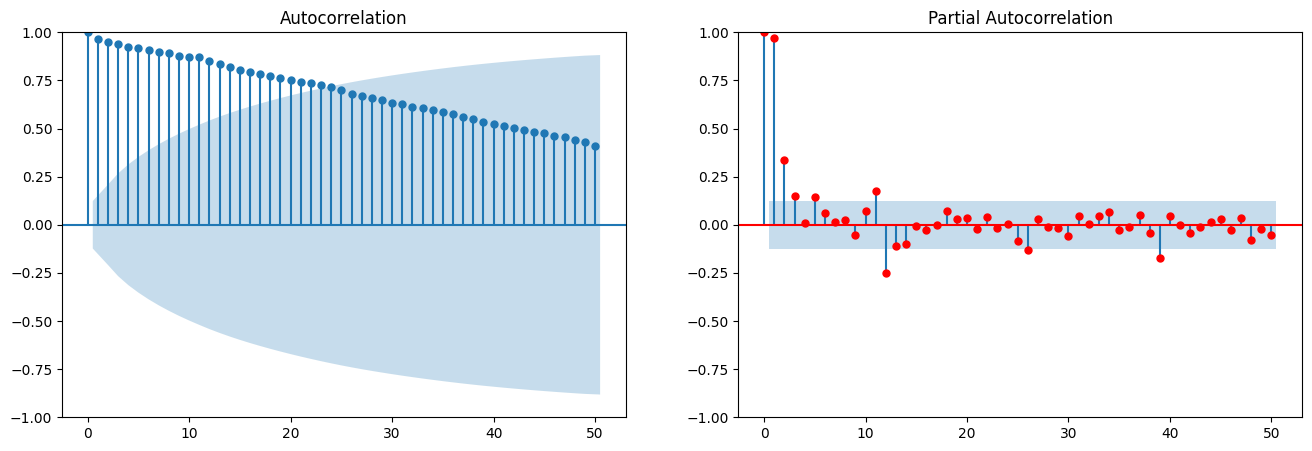

In [329]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

plot_acf(time_series_2019['deseasonalized'], lags=50, ax=axes[0]);
plot_pacf(time_series_2019['deseasonalized'], lags=50, ax=axes[1], color='r');

In [234]:
ndiffs(time_series_2019['deseasonalized'])

1

In [332]:
train=time_series_2019['deseasonalized']
test=time_series['deseasonalized'][-24:]

In [333]:
smodel = pm.auto_arima(train,
                       start_p=1, max_p=4,
                       start_q=1, max_q=25,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3938.262, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4008.556, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3964.944, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3944.222, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4008.556, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3939.535, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3939.980, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3940.138, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3955.071, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3940.568, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3938.262, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.198 seconds


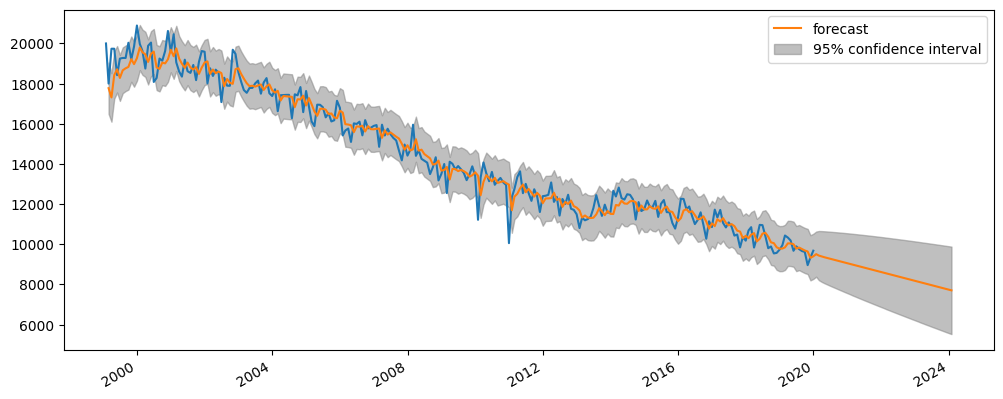

In [334]:
arima_2019 = ARIMA(train, order=(1, 1, 1), trend='t')
arima_2019 = arima_2019.fit()
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(time_series_2019['deseasonalized'])
plot_predict(arima_2019, start=1, end=300, ax=axs);

In [265]:


# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);



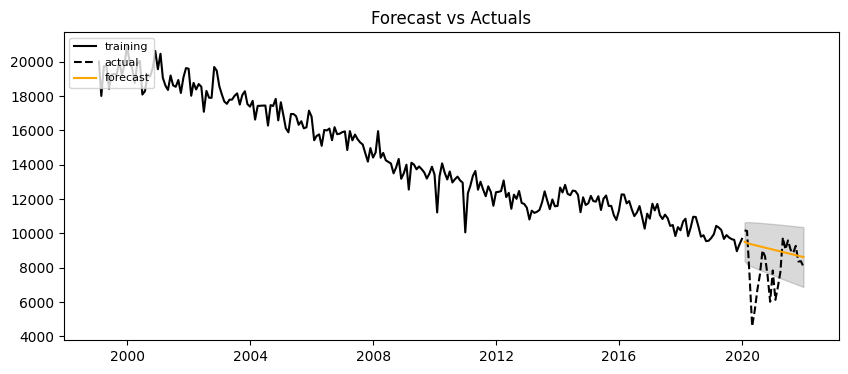

In [335]:

forecast_results = arima_2019.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

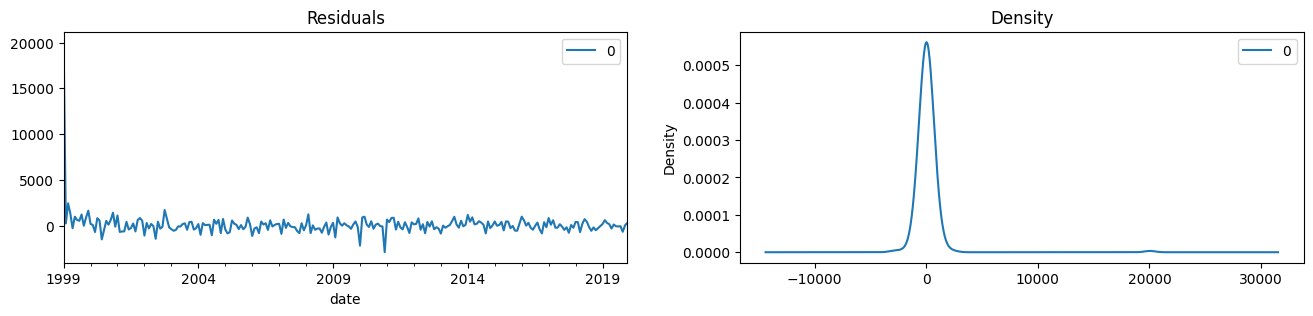

In [336]:


residuals = pd.DataFrame(arima_2019.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);



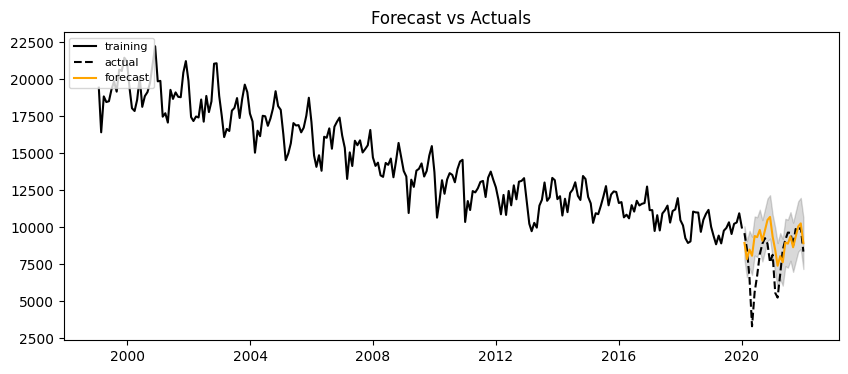

In [337]:
forecast_recons = forecast + result_add.seasonal[len(train):]
train_recons = train+ result_add.seasonal[0:len(train)]
test_recons = test+result_add.seasonal[len(train):]
lower_recons =confidence_int[:, 0]+ result_add.seasonal[len(train):]
upper_recons = confidence_int[:, 1] + result_add.seasonal[len(train):]

plt.figure(figsize=(10,4))
plt.plot(train_recons, label='training', color='black')
plt.plot(test_recons, label='actual', color='black', ls='--')
plt.plot(forecast_recons, label='forecast', color='orange')
plt.fill_between(lower_recons.index, lower_recons, upper_recons, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

In [283]:
data_2022=pd.read_csv('~/code/MagicaBleps/UK-road-safety/raw_data/dft-road-casualty-statistics-accident-provisional-mid-year-unvalidated-2022.csv')
data_2022['date']=pd.to_datetime(data_2022['date'])
time_series_2022=pd.DataFrame(data_2022[['date','accident_index']].set_index('date').resample('M').size())
time_series_2022.columns=['Accidents']


/tmp/ipykernel_6272/3021790696.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data_2022['date']=pd.to_datetime(data_2022['date'])


## Using real data from 2020 and 2021

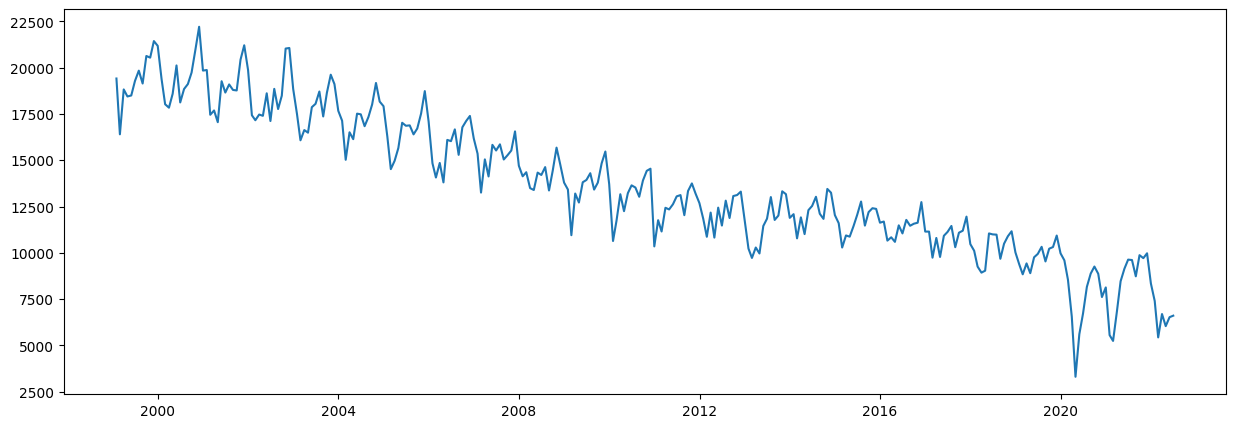

In [436]:
time_series_total=pd.concat([time_series,time_series_2022])
time_series_total=time_series_total[:time_series_total.shape[0]-6]
plt.figure(figsize=(15,5))
plt.plot(time_series_total['Accidents'])

Text(0.5, 1.0, 'Multiplicative residuals plot')

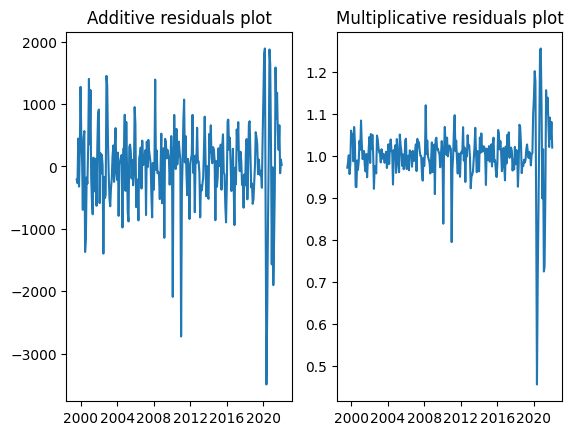

In [338]:
result_add = seasonal_decompose(time_series_total['Accidents'], model='additive')
result_mul = seasonal_decompose(time_series_total['Accidents'], model='multiplicative')
plt.subplot(1,2,1)
plt.plot(result_add.resid)
plt.title('Additive residuals plot')
plt.subplot(1,2,2)
plt.plot(result_mul.resid)
plt.title('Multiplicative residuals plot')

In [339]:
time_series_total['deseasonalized']=time_series_total['Accidents'].values-result_add.seasonal

In [340]:
train=time_series_total[:time_series_total.shape[0]-6]
test=time_series_total[time_series_total.shape[0]-6:]

In [341]:
smodel = pm.auto_arima(train['deseasonalized'],
                       start_p=1, max_p=10,
                       start_q=1, max_q=25,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4392.602, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4439.508, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4414.707, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4407.677, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4439.508, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4393.811, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4394.093, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4400.337, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4412.751, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4395.547, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4392.602, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.536 seconds


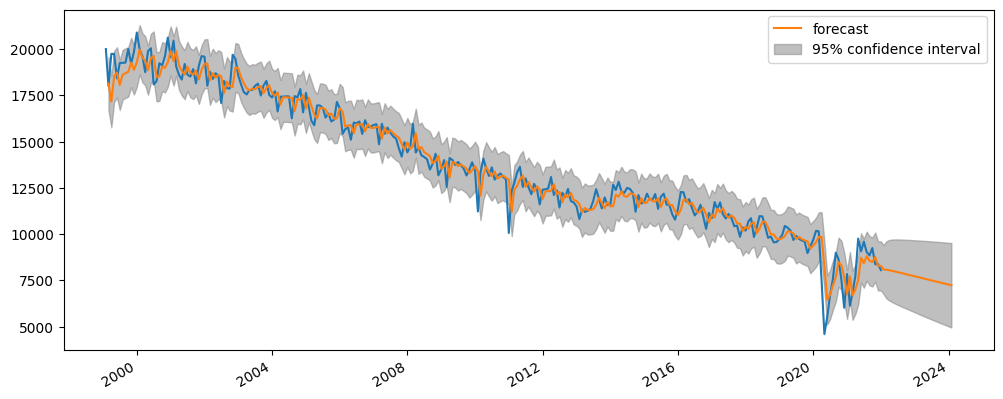

In [342]:
arima_total = ARIMA(train['deseasonalized'], order=(1, 1, 1), trend='t')
arima_total = arima_total.fit()
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train['deseasonalized'])
plot_predict(arima_total, start=1, end=300, ax=axs);

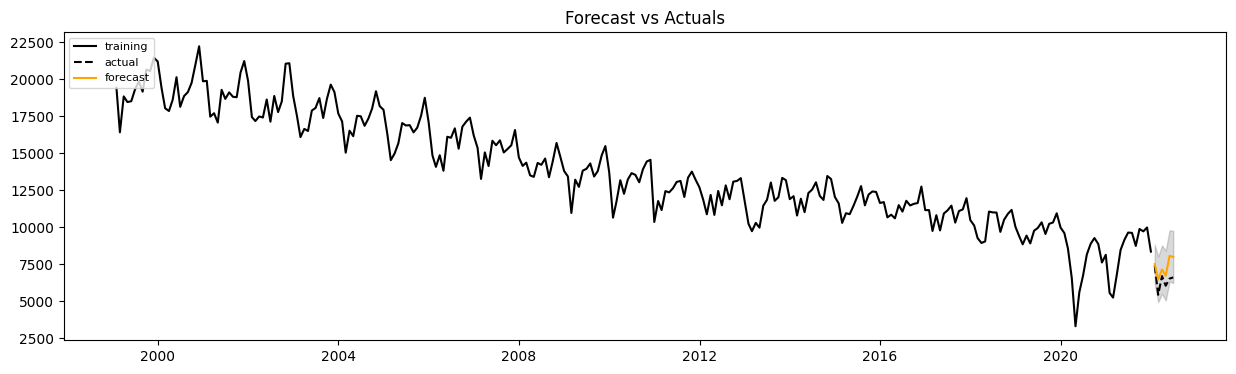

In [345]:
forecast_results = arima_total.get_forecast(len(test), alpha=0.05)
forecast_recons = forecast_results.predicted_mean+result_add.seasonal[len(train):]
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test.index)+ result_add.seasonal[len(train):]
upper_series = pd.Series(confidence_int[:,1], index=test.index)+ result_add.seasonal[len(train):]
train_recons=train['deseasonalized']+ result_add.seasonal[:len(train)]
test_recons=test['deseasonalized']+ result_add.seasonal[len(train):]
plt.figure(figsize=(15,4))
plt.plot(train_recons, label='training', color='black')
plt.plot(test_recons, label='actual', color='black', ls='--')
plt.plot(forecast_recons, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

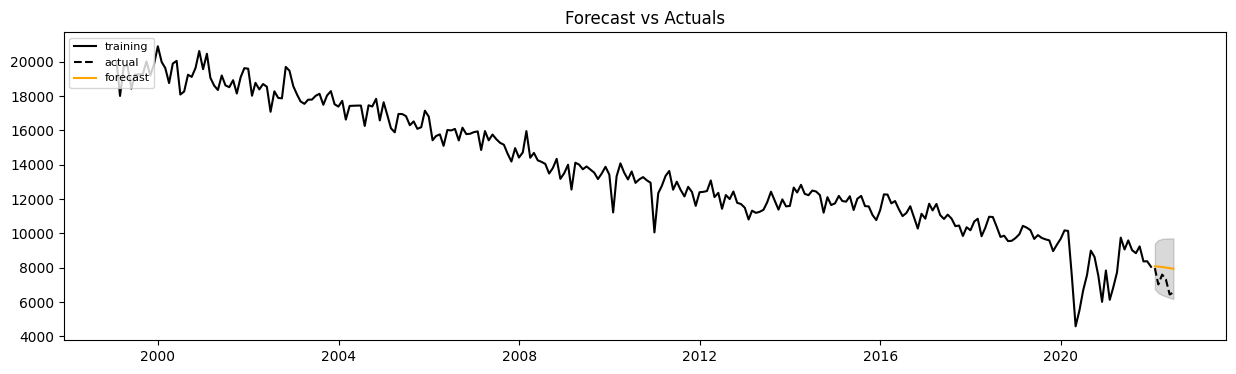

In [346]:
forecast_results = arima_total.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test.index)
upper_series = pd.Series(confidence_int[:,1], index=test.index)
plt.figure(figsize=(15,4))
plt.plot(train['deseasonalized'], label='training', color='black')
plt.plot(test['deseasonalized'], label='actual', color='black', ls='--')
plt.plot(forecast, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

## Using predicted data from 2020 and 2021

In [397]:
fc_2020_2021=pd.DataFrame((arima_2019.forecast(24, alpha=0.05)+result_add_2019.seasonal[len(time_series_2019['deseasonalized']):]).astype(int))
fc_2020_2021.columns=['Accidents']
fc_2020_2021.columns


Index(['Accidents'], dtype='object')

In [398]:
train=pd.concat([time_series_2019[['Accidents']],fc_2020_2021])

In [422]:
test=pd.DataFrame(time_series_total['Accidents'][time_series_total.shape[0]-6:])
test.columns=['Accidents']

In [424]:
time_series_final=pd.concat([train,test])
time_series_final.tail(10)

,Accidents
2021-09-30,9329
2021-10-31,10042
2021-11-30,10248
2021-12-31,8909
2022-01-31,7394
2022-02-28,5426
2022-03-31,6689
2022-04-30,6035
2022-05-31,6519
2022-06-30,6601


Text(0.5, 1.0, 'Multiplicative residuals plot')

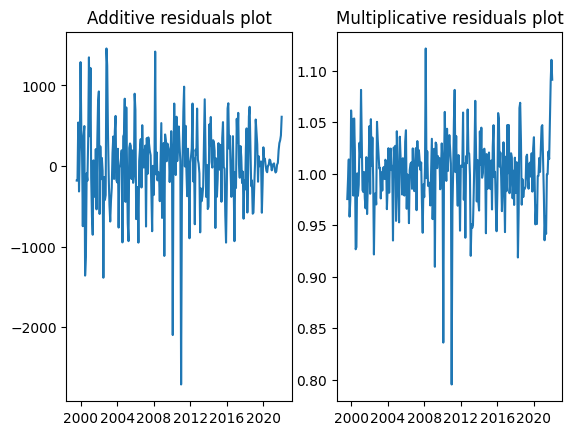

In [425]:
result_add = seasonal_decompose(time_series_final['Accidents'], model='additive')
result_mul = seasonal_decompose(time_series_final['Accidents'], model='multiplicative')
plt.subplot(1,2,1)
plt.plot(result_add.resid)
plt.title('Additive residuals plot')
plt.subplot(1,2,2)
plt.plot(result_mul.resid)
plt.title('Multiplicative residuals plot')

In [426]:
time_series_final['deseasonalized']=time_series_final['Accidents']/result_mul.seasonal

In [427]:
train_final=time_series_final['deseasonalized'][:len(train)]
test_final=time_series_final['deseasonalized'][len(train):]

In [428]:
smodel = pm.auto_arima(train_final,
                       start_p=1, max_p=10,
                       start_q=1, max_q=25,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4288.136, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4377.436, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4323.348, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4292.128, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4377.436, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4290.400, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4290.063, Time=0.40 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4289.375, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4308.278, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4288.136, Time=0.26 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 2.488 seconds


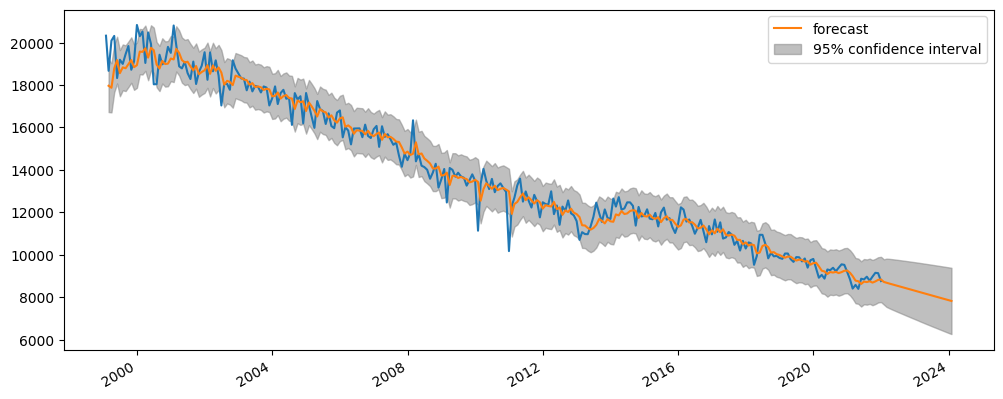

In [430]:
arima_final=ARIMA(train_final, order=(1, 1, 1), trend='t')
arima_final = arima_final.fit()
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_final)
plot_predict(arima_final, start=1, end=300, ax=axs);

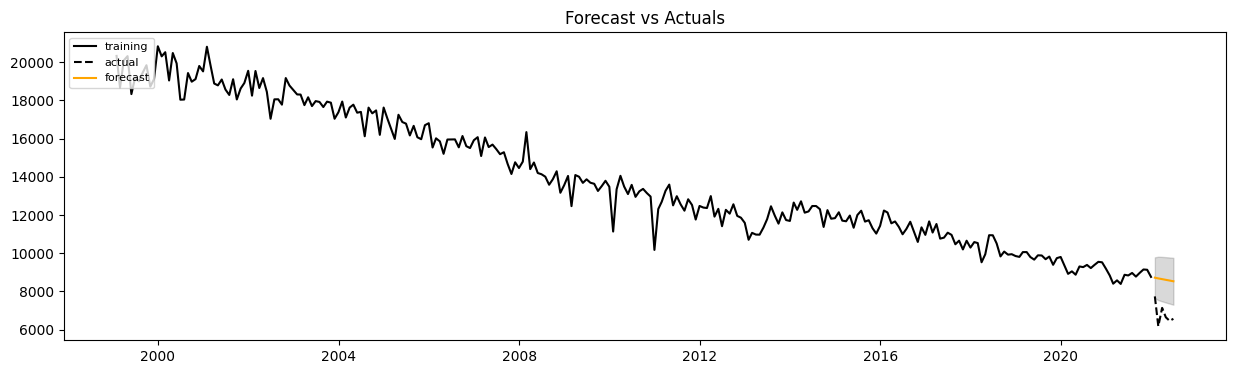

In [431]:
forecast_results = arima_final.get_forecast(len(test_final), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test_final.index)
upper_series = pd.Series(confidence_int[:,1], index=test_final.index)
plt.figure(figsize=(15,4))
plt.plot(train_final, label='training', color='black')
plt.plot(test_final, label='actual', color='black', ls='--')
plt.plot(forecast, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

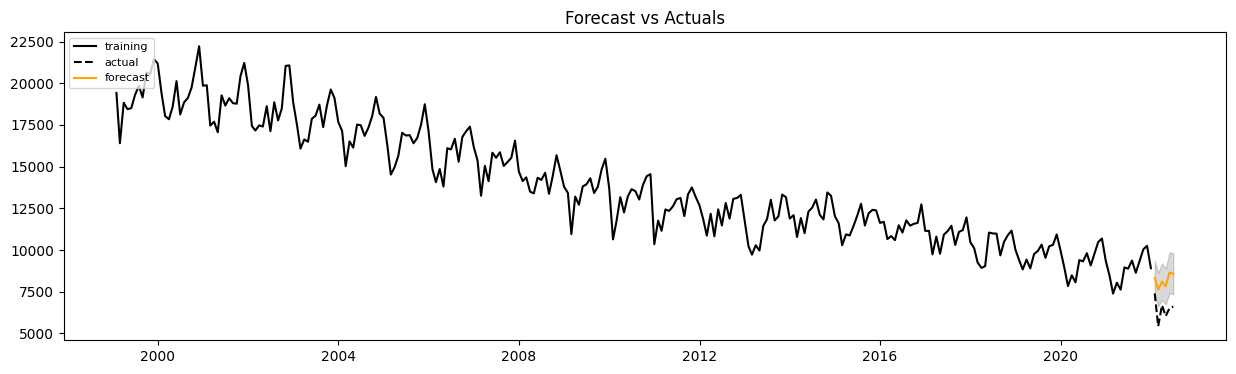

In [433]:
forecast_results = arima_final.get_forecast(len(test_final), alpha=0.05)
forecast_recons = forecast_results.predicted_mean*result_mul.seasonal[len(train_final):]
confidence_int = forecast_results.conf_int().values
lower_series = pd.Series(confidence_int[:,0], index=test_2021.index)*result_mul.seasonal[len(train_final):]
upper_series = pd.Series(confidence_int[:,1], index=test_2021.index)*result_mul.seasonal[len(train_final):]
train_recons=train_final*result_mul.seasonal[:len(train_final)]
test_recons=test_final*result_mul.seasonal[len(train_final):]
plt.figure(figsize=(15,4))
plt.plot(train_recons, label='training', color='black')
plt.plot(test_recons, label='actual', color='black', ls='--')
plt.plot(forecast_recons, label='forecast', color='orange')
plt.fill_between(lower_series.index,lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8);

# Geohash gcpvj0

In [162]:
df_gcpvj0=df_accidents[df_accidents['geohash']=='gcpvj0']
time_series_gcpvj0=data_for_analysis(df_gcpvj0,'M')

In [71]:
df_gcpvj0_2019=df_accidents[(df_accidents['geohash']=='gcpvj0')&(df_accidents['accident_year']<2020)]
time_series_gcpvj0_2019=data_for_analysis(df_gcpvj0_2019,'M')
time_series_gcpvj0_2019.tail()

,Accidents
date,
2019-08-31,7
2019-09-30,8
2019-10-31,5
2019-11-30,1
2019-12-31,3


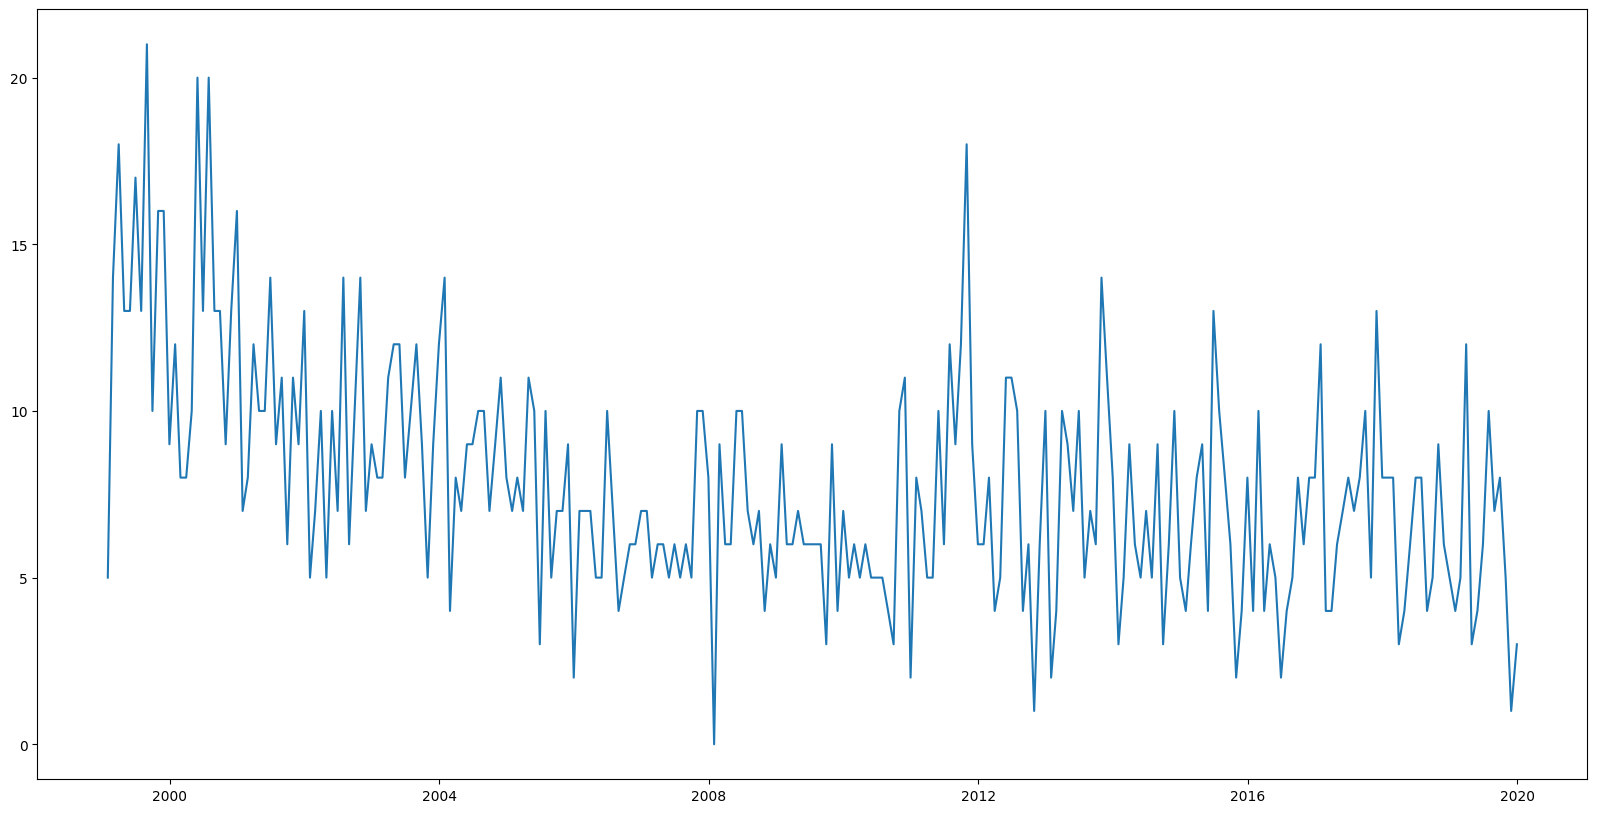

In [38]:
plt.figure(figsize=(20,10))
plt.plot(time_series_gcpvj0_2019);

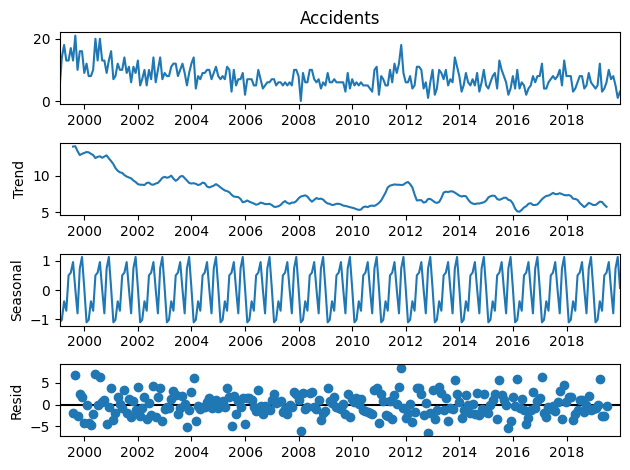

In [72]:
result_add = seasonal_decompose(time_series_gcpvj0_2019['Accidents'], model='additive')
result_add.plot();

Text(0.5, 1.0, 'Additive residuals plot')

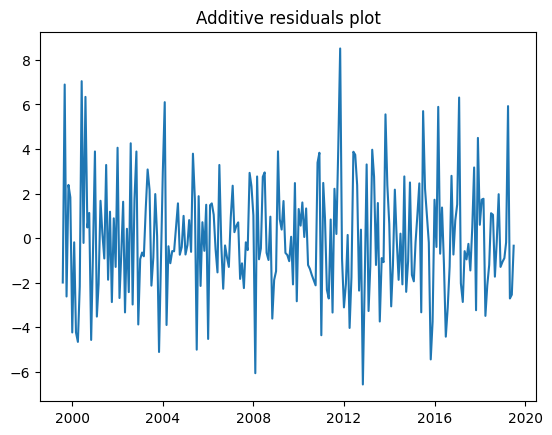

In [87]:
plt.plot(result_add.resid)
plt.title('Additive residuals plot')

In [74]:
adfuller(time_series_gcpvj0_2019['Accidents'])[1]

0.012683224159440915

In [75]:
adfuller(result_add.resid.dropna())[1]

6.76862561044716e-18

In [102]:
time_series_gcpvj0_2019['deseasonalized']=time_series_gcpvj0_2019['Accidents'].values-result_add.seasonal

In [101]:
time_series_gcpvj0_2019.head(10)

,Accidents,deseasonalized,diffed
date,,,
1999-01-31,5,6.101562,NaN
1999-02-28,14,15.016146,9.0
1999-03-31,18,18.382812,4.0
1999-04-30,13,13.705729,-5.0
1999-05-31,13,12.501563,0.0
1999-06-30,17,16.407812,4.0
1999-07-31,13,12.047396,-4.0
1999-08-31,21,20.976562,8.0
1999-09-30,10,10.795312,-11.0


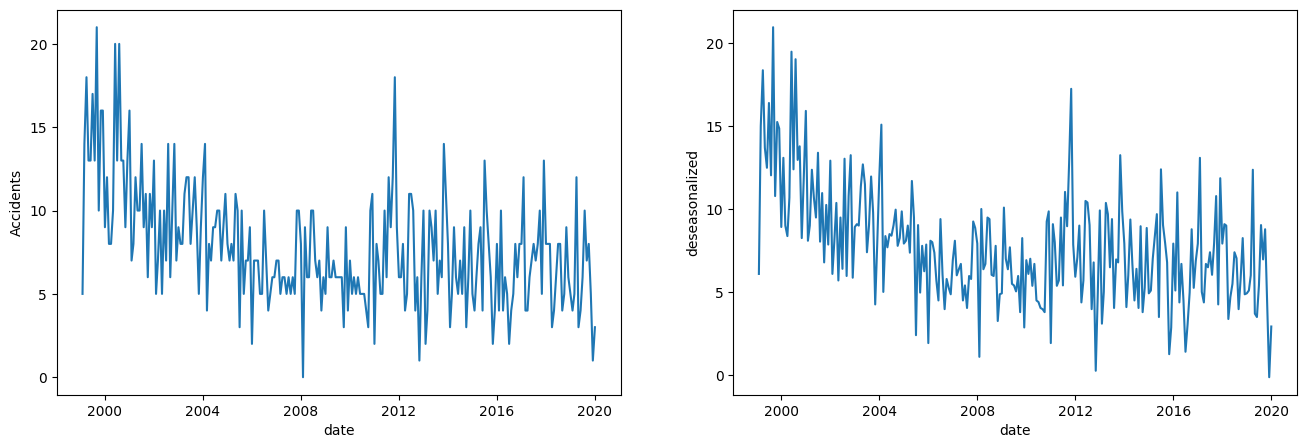

In [99]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

sns.lineplot(time_series_gcpvj0_2019['Accidents'], ax=axes[0])
sns.lineplot(time_series_gcpvj0_2019['deseasonalized'], ax=axes[1]);

In [94]:
d=ndiffs(time_series_gcpvj0_2019['deseasonalized'])
d

1

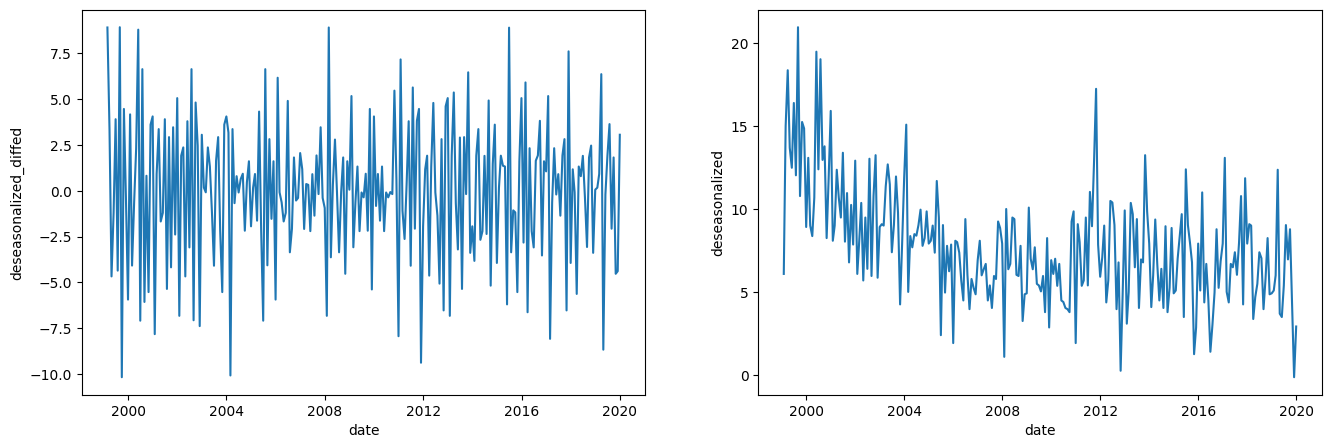

In [103]:
time_series_gcpvj0_2019['deseasonalized_diffed']=time_series_gcpvj0_2019['deseasonalized'].diff()
fig, axes = plt.subplots(1,2, figsize=(16,5))
sns.lineplot(time_series_gcpvj0_2019['deseasonalized_diffed'], ax=axes[0])
sns.lineplot(time_series_gcpvj0_2019['deseasonalized'], ax=axes[1]);

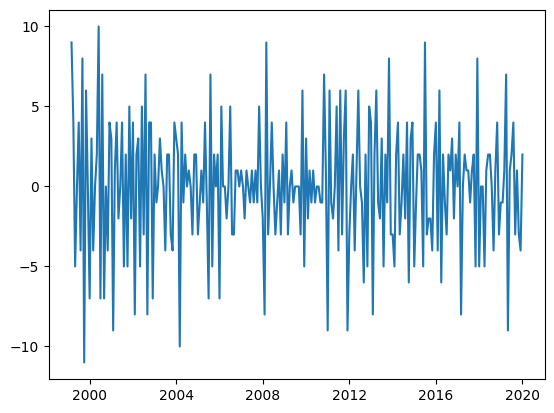

In [104]:
time_series_gcpvj0_2019['diffed']=time_series_gcpvj0_2019['Accidents'].diff()
plt.plot(time_series_gcpvj0_2019['diffed'])

/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


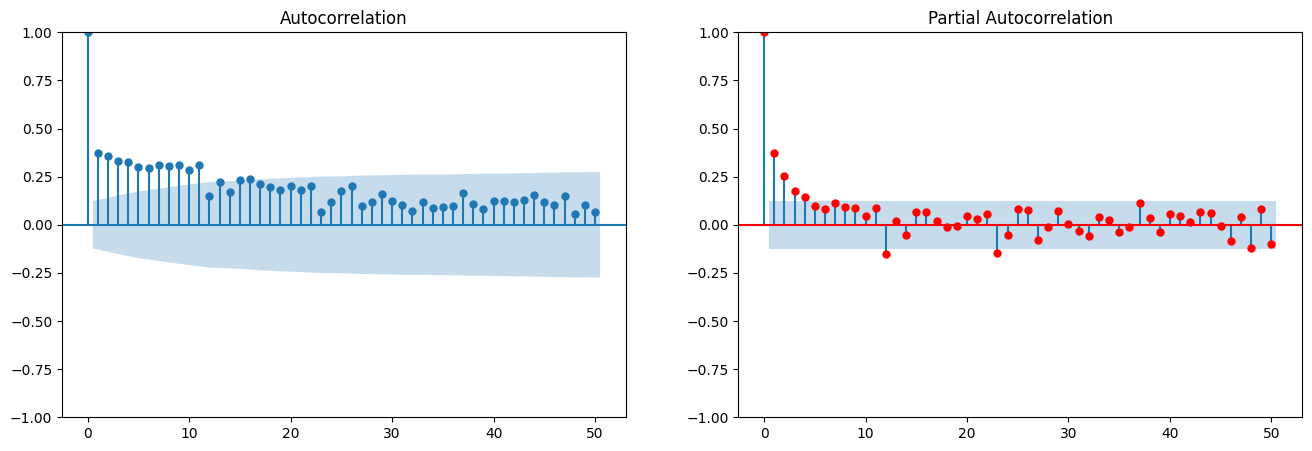

In [108]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

plot_acf(time_series_gcpvj0_2019['deseasonalized'], lags=50, ax=axes[0]);
plot_pacf(time_series_gcpvj0_2019['deseasonalized'], lags=50, ax=axes[1], color='r');


/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/matplotlib/axes/_base.py:2539: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


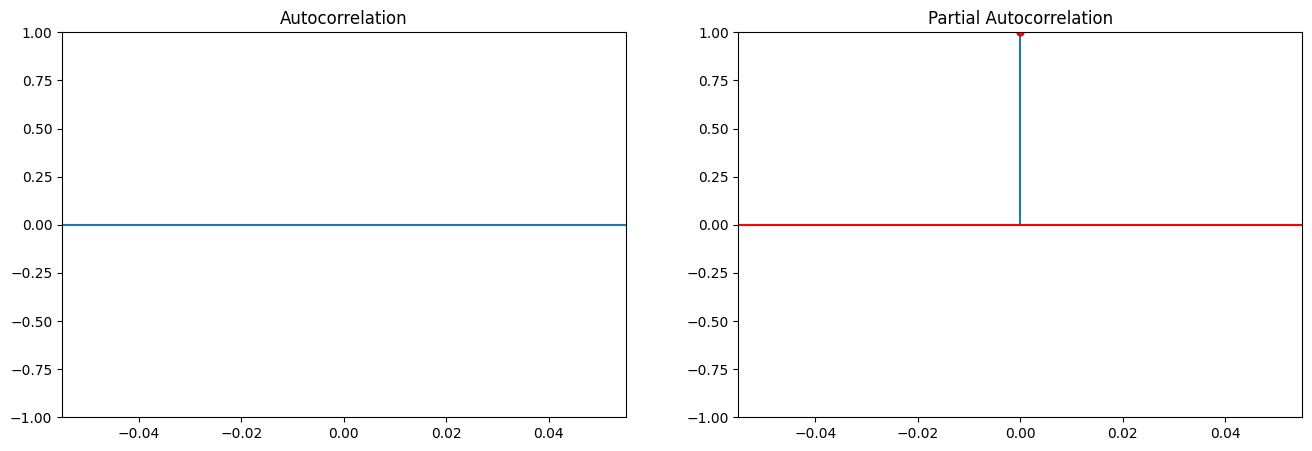

In [119]:
fig, axes = plt.subplots(1,2, figsize=(16,5))

plot_acf(time_series_gcpvj0_2019['diffed'], lags=50, ax=axes[0]);
plot_pacf(time_series_gcpvj0_2019['diffed'], lags=50, ax=axes[1], color='r');

In [89]:
p=4
q=11

In [109]:
arima = ARIMA(time_series_gcpvj0_2019['diffed'], order=(p, d, q), trend='t')
arima = arima.fit()

/home/ele/.pyenv/versions/3.10.6/envs/UK-road-safety/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [110]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         deseasonalized   No. Observations:                  252
Model:                ARIMA(4, 1, 11)   Log Likelihood                -615.967
Date:                Sun, 11 Dec 2022   AIC                           1265.934
Time:                        18:43:02   BIC                           1325.867
Sample:                    01-31-1999   HQIC                          1290.052
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0309      0.018     -1.745      0.081      -0.066       0.004
ar.L1          0.3613      0.250      1.446      0.148      -0.128       0.851
ar.L2         -0.0665      0.111     -0.600      0.548      -0.284       0.151
ar.L3         -0.7202      0.119     -6.051      0.000      -0.953      -0.487
ar.L4          0.5783      0.218      2.649      0.008       0.150       1.006
ma.L1         -1.2873      0.263     -4.903      0.000      -1.802      -0.773
ma.L2          0.4208      0.301      1.398      0.162      -0.169       1.011
ma.L3          0.6931      0.240      2.884      0.004       0.222       1.164
ma.L4         -1.2994      0.257     -5.061      0.000      -1.803      -0.796
ma.L5          0.5711      0.238      2.396      0.017       0.104       1.038
ma.L6         -0.0216      0.148     -0.146      0.884      -0.312       0.268
ma.L7          0.1010      0.157      0.645      0.519      -0.206       0.408
ma.L8         -0.1213      0.128     -0.951      0.342      -0.372       0.129
ma.L9          0.0879      0.122      0.718      0.473      -0.152       0.328
ma.L10         0.0756      0.134      0.563      0.574      -0.188       0.339
ma.L11        -0.1517      0.082     -1.852      0.064      -0.312       0.009
sigma2         7.8398      0.763     10.272      0.000       6.344       9.336
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 8.32
Prob(Q):                              0.64   Prob(JB):                         0.02
Heteroskedasticity (H):               0.90   Skew:                             0.40
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [140]:
smodel = pm.auto_arima(time_series_gcpvj0_2019['Accidents'].dropna(),
                       start_p=1, max_p=12,
                       start_q=1, max_q=5,
                       trend='t',
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1271.395, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1403.173, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1341.770, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1269.001, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1403.173, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1270.725, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1276.781, Time=0.37 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1269.001, Time=0.16 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 1.486 seconds


In [141]:
arima = ARIMA(time_series_gcpvj0_2019['Accidents'], order=(0, 1, 1), trend='t')
arima = arima.fit()

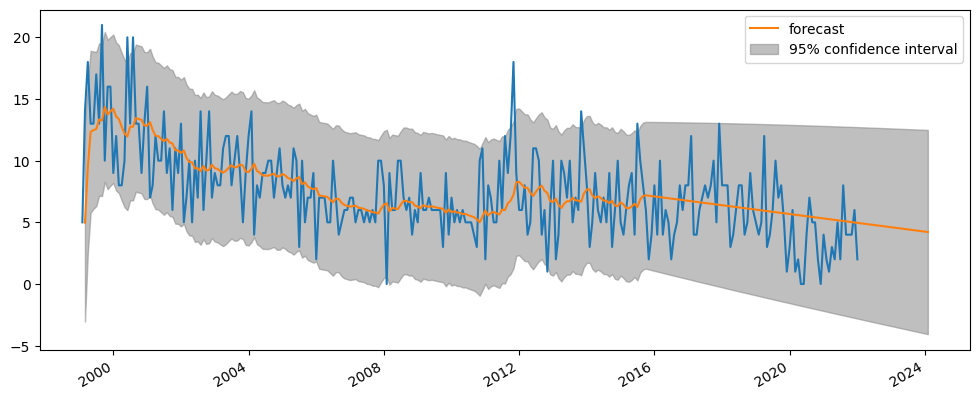

In [163]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(time_series_gcpvj0['Accidents'])
plot_predict(arima, start=1, end=300, ax=axs);

In [143]:
train = time_series_gcpvj0_2019['Accidents'][0:200]
test = time_series_gcpvj0_2019['Accidents'][200:]

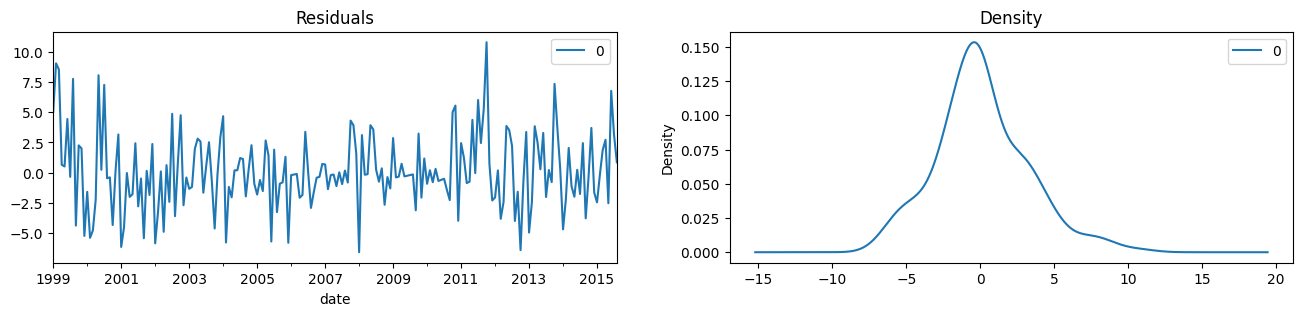

In [147]:


residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);



In [166]:
data_2022=prepare_data_for_groupby(data_2022,6)

In [167]:
data_2022.head()

,status,accident_year,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,IsWeekend,month,Daytime,geohash
